# Sign Recognition Project

In [21]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import xml.etree.ElementTree as ET
import random
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


Dataset Extraction

In [22]:
DATASET_DIR = "."
IMAGES_DIR = "./road-sign-detection/images"
ANN_DIR = "./road-sign-detection/annotations"

print("Number of images :", len(os.listdir(IMAGES_DIR)))
print("Number of annotations :", len(os.listdir(ANN_DIR)))


Number of images : 877
Number of annotations : 877


In [23]:
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find("filename").text
    objects = []
    
    for obj in root.findall("object"):
        name = obj.find("name").text
        bnd = obj.find("bndbox")
        xmin = int(bnd.find("xmin").text)
        ymin = int(bnd.find("ymin").text)
        xmax = int(bnd.find("xmax").text)
        ymax = int(bnd.find("ymax").text)
        objects.append({
            "label": name,
            "bbox": (xmin, ymin, xmax, ymax)
        })
    
    return filename, objects


Images formatting for training

In [24]:
IMG_SIZE = 96
X = []
y = []

xml_files = sorted(glob.glob(ANN_DIR + "/*.xml"))
for xml_path in xml_files:
    filename, objects = parse_voc_xml(xml_path)
    img_path = IMAGES_DIR + "/" + filename
    if not os.path.exists(img_path):
        continue
    img = Image.open(img_path).convert("RGB")
    for obj in objects:
        label = obj["label"]
        xmin, ymin, xmax, ymax = obj["bbox"]
        crop = img.crop((xmin, ymin, xmax, ymax))
        crop = crop.resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(crop))
        y.append(label)
X = np.array(X)
y = np.array(y)

print("Extracted images :", X.shape)
print("Labels :", np.unique(y))


Extracted images : (1244, 96, 96, 3)
Labels : ['crosswalk' 'speedlimit' 'stop' 'trafficlight']


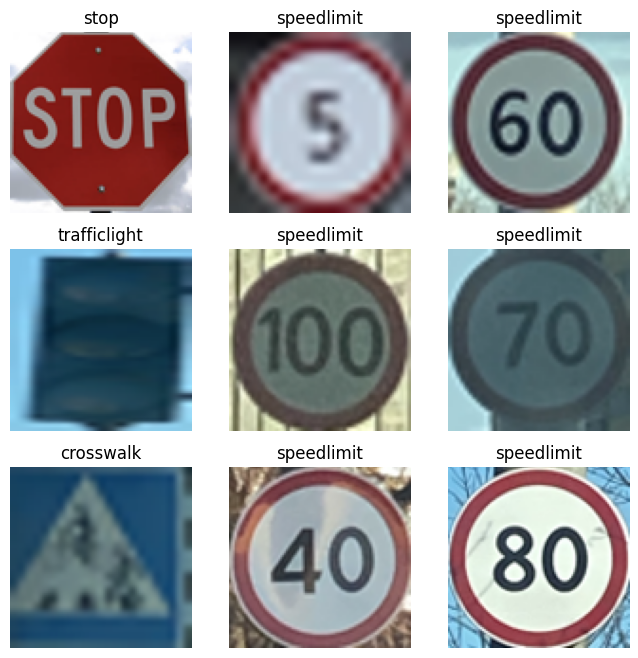

In [25]:
plt.figure(figsize=(8,8))
for i in range(9):
    idx = random.randint(0, len(X)-1)
    plt.subplot(3,3,i+1)
    plt.imshow(X[idx].astype("uint8"))
    plt.title(y[idx])
    plt.axis('off')
plt.show()


## Preparing the Dataset

In [26]:
X = X.astype("float32") / 255.0
X_flat = X.reshape(X.shape[0], -1)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)
print("Classes :", label_encoder.classes_)


Train : (995, 27648) (995,)
Test  : (249, 27648) (249,)
Classes : ['crosswalk' 'speedlimit' 'stop' 'trafficlight']


## Comparison of classifiers

### Multinomial Logistic Regression

In [27]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.99      0.99      0.99       157
           2       0.86      1.00      0.92        18
           3       0.94      0.88      0.91        34

    accuracy                           0.97       249
   macro avg       0.95      0.96      0.95       249
weighted avg       0.97      0.97      0.97       249



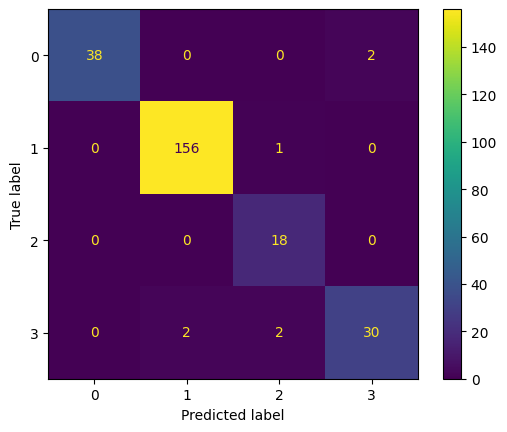

In [28]:
predicted = clf_lr.predict(X_test)
print(metrics.classification_report(y_test, predicted))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
plt.show()

### Support Vector Machine

In [29]:
cls_svm = svm.SVC()
cls_svm.fit(X_train,y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.99      0.99      0.99       157
           2       1.00      0.94      0.97        18
           3       0.89      0.97      0.93        34

    accuracy                           0.98       249
   macro avg       0.97      0.96      0.97       249
weighted avg       0.98      0.98      0.98       249



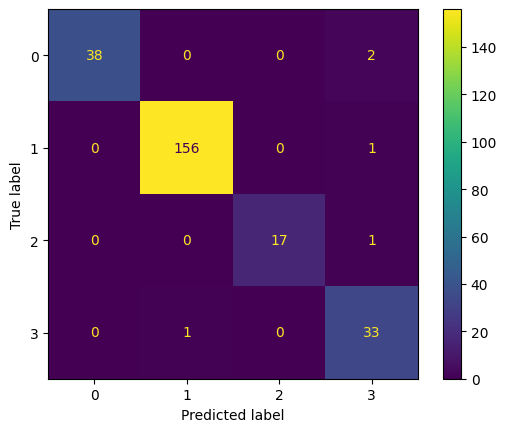

In [30]:
predicted = cls_svm.predict(X_test)
print(metrics.classification_report(y_test, predicted))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
plt.show()

## Gaussian Naive Bayes

In [31]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


              precision    recall  f1-score   support

           0       0.78      0.88      0.82        40
           1       0.96      0.82      0.88       157
           2       0.79      0.83      0.81        18
           3       0.58      0.88      0.70        34

    accuracy                           0.84       249
   macro avg       0.78      0.85      0.80       249
weighted avg       0.87      0.84      0.84       249



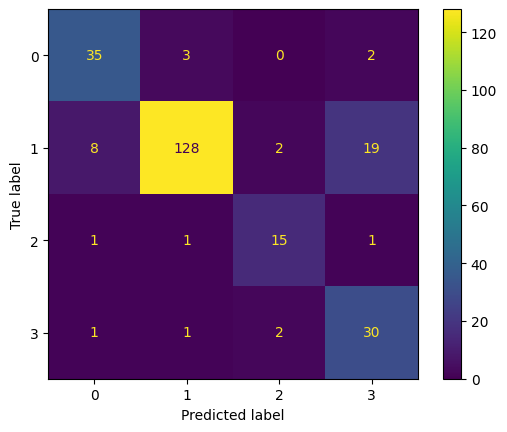

In [32]:
y_pred_gnb = gnb.predict(X_test)
print(classification_report(y_test, y_pred_gnb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gnb, cmap='viridis')
plt.show()

## K Nearest Neighbors

In [33]:
cls_knn = KNeighborsClassifier(n_neighbors=5)
cls_knn.fit(X_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.92      0.99      0.95       157
           2       0.83      0.83      0.83        18
           3       1.00      0.62      0.76        34

    accuracy                           0.92       249
   macro avg       0.92      0.84      0.87       249
weighted avg       0.92      0.92      0.91       249



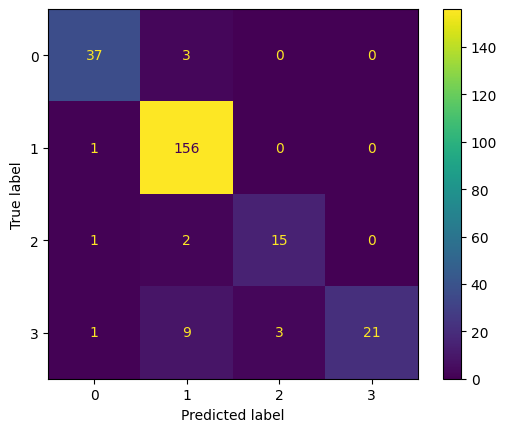

In [34]:
predicted = cls_knn.predict(X_test)
print(metrics.classification_report(y_test, predicted))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
plt.show()

Parameters tuning to find the best accuracy

In [35]:
best_accuracy = 0
best_params = {}
for n_neighbors in range(1, 11):
    for weights in ['uniform', 'distance']:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_neighbors': n_neighbors, 'weights': weights}
print(f'Best accuracy: {best_accuracy}')
print(f'Best parameters: {best_params}')

Best accuracy: 0.9437751004016064
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}


## Conclusion

Even if it takes time to run, the most accurate classifier is the Support Vector Machine classifier

After obtaining the satisfying accuracy display numbers which the model misclassified.

ValueError: cannot reshape array of size 27648 into shape (8,8)

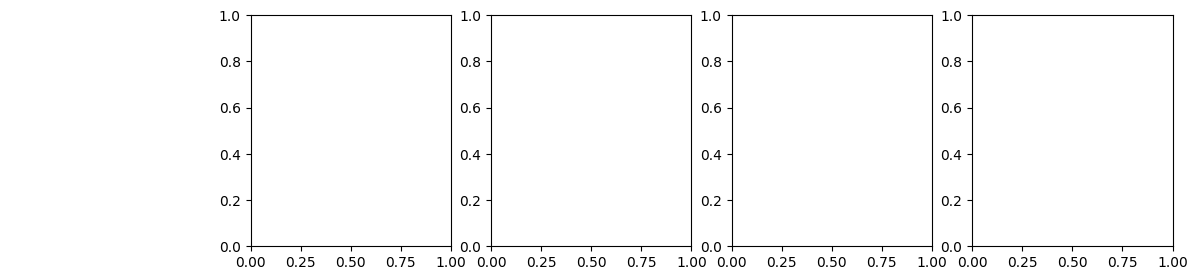

In [36]:

#knn = KNeighborsClassifier(**best_params)
#knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)
predicted = cls_svm.predict(X_test)
misclassified_indices = np.where(predicted != y_test)[0]
fig, axes = plt.subplots(nrows=1, ncols=len(misclassified_indices), figsize=(15, 3))
for ax, index in zip(axes, misclassified_indices):
    ax.set_axis_off()
    ax.imshow(X_test[index].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'True:{y_test[index]}\nPred:{predicted[index]}')
plt.show()